# Camera estimation

In [2]:
import cv2
import numpy as np
import supervision as sv
from ultralytics import YOLO


In [6]:
SOURCE_VIDEO_PATH="../data/input/test_video.mp4"

KEYPOINTS_DETECTION_MODEL_PATH = "../models/keypoints_detection500.pt"
KEYPOINTS_DETECTION_MODEL = YOLO(KEYPOINTS_DETECTION_MODEL_PATH)

PLAYER_INFERENCE_MODEL_PATH = "../models/player_inference.pt"
PLAYER_INFERENCE_MODEL = YOLO(PLAYER_INFERENCE_MODEL_PATH)

BALL_INFERENCE_MODEL_PATH = "../models/ball_inference.pt"
BALL_INFERENCE_MODEL = YOLO(BALL_INFERENCE_MODEL_PATH)


In [ ]:
vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex("#FF1493"),
    radius=7
)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)
height, width, _ = frame.shape
frame_image_resized = cv2.resize(frame, (640, 640))

result = KEYPOINTS_DETECTION_MODEL.predict(frame_image_resized, conf=0.3)[0]
keypoints = sv.KeyPoints.from_ultralytics(result)
keypoints.xy[0] = keypoints.xy[0] / 640 * np.array([width, height]).T

# remove random keypoints using confidence if needed
filter = keypoints.confidence[0] > 0.5
frame_reference_points = keypoints.xy[0][filter]
frame_reference_keypoints = sv.KeyPoints(xy=frame_reference_points[np.newaxis, ...])

annotated_frame = frame.copy()
annotated_frame = vertex_annotator.annotate(annotated_frame, frame_reference_keypoints)

sv.plot_image(annotated_frame)

### Project pitch lines on frame

In [194]:
from football_analytics.football_pitch.draw_football_pitch import (
    draw_football_pitch,
    draw_points_on_pitch,
)
from football_analytics.football_pitch.football_pitch_configuration import (
    FootballPitchConfiguration,
)

CONFIG = FootballPitchConfiguration()

In [ ]:
annotated_frame = draw_football_pitch(CONFIG)

sv.plot_image(annotated_frame)

In [199]:
from football_analytics.football_pitch.view_transformer import ViewTransformer

In [ ]:
vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex("#FF1493"),
    radius=7
)
edge_annotator = sv.EdgeAnnotator(
    color=sv.Color.from_hex('00BFFF'),
    thickness=2,
    edges=CONFIG.edges
)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)
frame = next(frame_generator)
frame = next(frame_generator)
frame = next(frame_generator)

height, width, _ = frame.shape
frame_image_resized = cv2.resize(frame, (640, 640))

result = KEYPOINTS_DETECTION_MODEL.predict(frame_image_resized, conf=0.3)[0]
keypoints = sv.KeyPoints.from_ultralytics(result)
keypoints.xy[0] = keypoints.xy[0] / 640 * np.array([width, height]).T

# remove random keypoints using confidence if needed
filter = keypoints.confidence[0] > 0.5
frame_reference_points = keypoints.xy[0][filter]
frame_reference_keypoints = sv.KeyPoints(xy=frame_reference_points[np.newaxis, ...])
pitch_reference_points = np.array(CONFIG.vertices)[filter]

view_transformer = ViewTransformer(
    source=pitch_reference_points,
    target=frame_reference_points
)

pitch_all_points = np.array(CONFIG.vertices)
frame_all_points = view_transformer.transform_points(pitch_all_points)
frame_all_keypoints = sv.KeyPoints(xy=frame_all_points[np.newaxis, ...])

annotated_frame = frame.copy()
annotated_frame = edge_annotator.annotate(annotated_frame, frame_all_keypoints)
annotated_frame = vertex_annotator.annotate(annotated_frame, frame_reference_keypoints)

sv.plot_image(annotated_frame)

### Players part

In [ ]:
GOALKEEPER_ID = 0
PLAYER_ID = 1
REFEREE_ID = 2

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)
frame = next(frame_generator)
frame = next(frame_generator)
frame = next(frame_generator)


result = PLAYER_INFERENCE_MODEL.predict(frame, conf=0.3)[0]
detections = sv.Detections.from_ultralytics(result)

result = BALL_INFERENCE_MODEL.predict(frame, conf=0.1)[0]
ball_detections = sv.Detections.from_ultralytics(result)

ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

players_detections = detections[detections.class_id == PLAYER_ID]
goalkeepers_detections = detections[detections.class_id == GOALKEEPER_ID]
referees_detections = detections[detections.class_id == REFEREE_ID]


result = KEYPOINTS_DETECTION_MODEL.predict(frame_image_resized, conf=0.3)[0]
keypoints = sv.KeyPoints.from_ultralytics(result)
# keypoints.xy[0] = keypoints.xy[0] / 640 * np.array([width, height]).T

# remove random keypoints using confidence if needed
filter = keypoints.confidence[0] > 0.5
frame_reference_points = keypoints.xy[0][filter]
frame_reference_keypoints = sv.KeyPoints(xy=frame_reference_points[np.newaxis, ...])
pitch_reference_points = np.array(CONFIG.vertices)[filter]

view_transformer = ViewTransformer(
    source=frame_reference_points,
    target=pitch_reference_points
)

# TODO Change for team classification

frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_ball_xy = view_transformer.transform_points(frame_ball_xy)

frame_players_xy = players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_players_xy = view_transformer.transform_points(frame_players_xy)

frame_goalkeepers_xy = goalkeepers_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_goalkeepers_xy = view_transformer.transform_points(frame_goalkeepers_xy)

frame_referees_xy = referees_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_referees_xy = view_transformer.transform_points(frame_referees_xy)

pitch = draw_football_pitch(config=CONFIG)

if pitch_ball_xy.size != 0:
    pitch = draw_points_on_pitch(
        config=CONFIG,
        xy=pitch_ball_xy,
        main_color=sv.Color.WHITE,
        edge_color=sv.Color.BLACK,
        radius=10,
        pitch=pitch
    )

if pitch_players_xy.size != 0:
    pitch = draw_points_on_pitch(
        config=CONFIG,
        xy=pitch_players_xy,
        main_color=sv.Color.RED,
        edge_color=sv.Color.BLACK,
        radius=16,
        pitch=pitch
    )

if pitch_goalkeepers_xy.size != 0:
    pitch = draw_points_on_pitch(
        config=CONFIG,
        xy=pitch_goalkeepers_xy,
        main_color=sv.Color.BLUE,
        edge_color=sv.Color.BLACK,
        radius=16,
        pitch=pitch
    )

if pitch_referees_xy.size != 0:
    pitch = draw_points_on_pitch(
        config=CONFIG,
        xy=pitch_referees_xy,
        main_color=sv.Color.YELLOW,
        edge_color=sv.Color.BLACK,
        radius=16,
        pitch=pitch
    )

sv.plot_image(pitch)

In [ ]:
from football_analytics.annotations.radar import generate_radar

generate_radar(frame, detections, ball_detections, keypoints)

Other testing

In [14]:
from football_analytics.football_pitch.draw_football_pitch import (
    draw_football_pitch,
    draw_points_on_pitch,
)
from football_analytics.football_pitch.football_pitch_configuration import (
    FootballPitchConfiguration,
)
from football_analytics.football_pitch.view_transformer import ViewTransformer


def generate_radar(
        frame: np.ndarray,
        detections: sv.Detections,
        ball_detections: sv.Detections,
        keypoints_detections: sv.KeyPoints,

    ):
    height, width, _ = frame.shape

    CONFIG = FootballPitchConfiguration()

    ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

    players_detections = detections[detections.class_id == PLAYER_ID]
    goalkeepers_detections = detections[detections.class_id == GOALKEEPER_ID]
    referees_detections = detections[detections.class_id == REFEREE_ID]

    # keypoints_detections.xy[0] = keypoints_detections.xy[0] / 640 * np.array([width, height]).T
    print(keypoints_detections)

    filter = keypoints_detections.confidence[0] > 0.5
    frame_reference_points = keypoints_detections.xy[0][filter]
    frame_reference_keypoints = sv.KeyPoints(xy=frame_reference_points[np.newaxis, ...])
    pitch_reference_points = np.array(CONFIG.vertices)[filter]

    view_transformer = ViewTransformer(
        source=frame_reference_points,
        target=pitch_reference_points
    )

    frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    pitch_ball_xy = view_transformer.transform_points(frame_ball_xy)

    frame_players_xy = players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    pitch_players_xy = view_transformer.transform_points(frame_players_xy)

    frame_goalkeepers_xy = goalkeepers_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    pitch_goalkeepers_xy = view_transformer.transform_points(frame_goalkeepers_xy)

    frame_referees_xy = referees_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    pitch_referees_xy = view_transformer.transform_points(frame_referees_xy)

    pitch = draw_football_pitch(config=CONFIG)


    if pitch_ball_xy.size != 0:
        pitch = draw_points_on_pitch(
            config=CONFIG,
            xy=pitch_ball_xy,
            main_color=sv.Color.WHITE,
            edge_color=sv.Color.BLACK,
            radius=10,
            pitch=pitch
        )

    if pitch_players_xy.size != 0:
        pitch = draw_points_on_pitch(
            config=CONFIG,
            xy=pitch_players_xy,
            main_color=sv.Color.RED,
            edge_color=sv.Color.BLACK,
            radius=16,
            pitch=pitch
        )

    if pitch_goalkeepers_xy.size != 0:
        pitch = draw_points_on_pitch(
            config=CONFIG,
            xy=pitch_goalkeepers_xy,
            main_color=sv.Color.BLUE,
            edge_color=sv.Color.BLACK,
            radius=16,
            pitch=pitch
        )

    if pitch_referees_xy.size != 0:
        pitch = draw_points_on_pitch(
            config=CONFIG,
            xy=pitch_referees_xy,
            main_color=sv.Color.YELLOW,
            edge_color=sv.Color.BLACK,
            radius=16,
            pitch=pitch
        )

    sv.plot_image(pitch)


0: 736x1280 19 players, 3 referees, 1560.8ms
Speed: 9.6ms preprocess, 1560.8ms inference, 0.8ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 (no detections), 1335.2ms
Speed: 4.3ms preprocess, 1335.2ms inference, 0.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 565.1ms
Speed: 1.4ms preprocess, 565.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)
KeyPoints(xy=array([[[          0,           0],
        [          0,           0],
        [          0,           0],
        [          0,           0],
        [          0,           0],
        [          0,           0],
        [          0,           0],
        [          0,           0],
        [          0,           0],
        [          0,           0],
        [          0,           0],
        [          0,           0],
        [          0,           0],
        [     1215.2,      325.82],
        [     1232.3,       455.8],
        [     1227.6,       589.5],

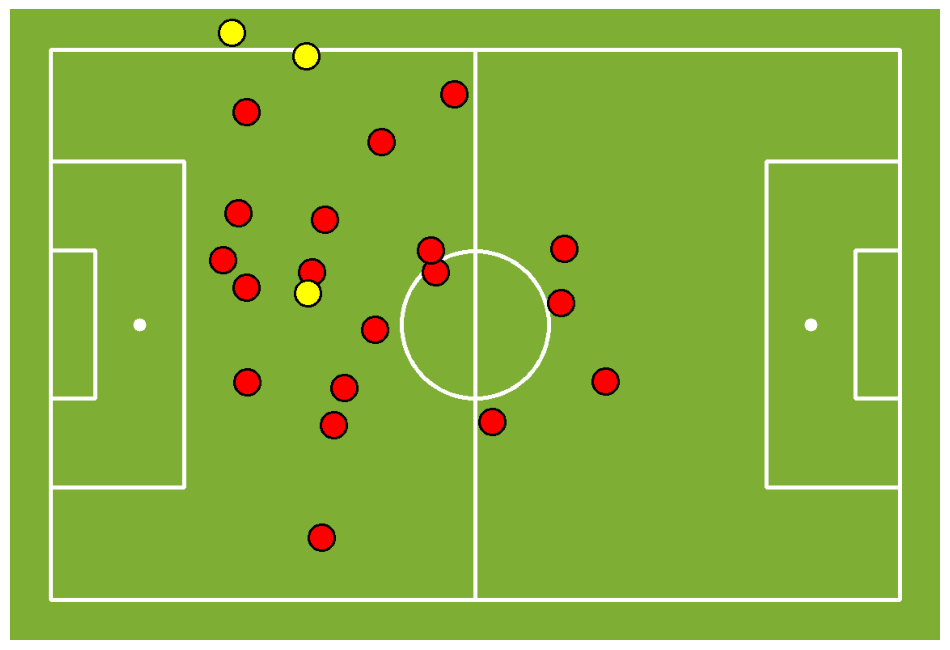

In [15]:
from football_analytics.utils.model import to_supervision

GOALKEEPER_ID = 0
PLAYER_ID = 1
REFEREE_ID = 2

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = PLAYER_INFERENCE_MODEL.predict(frame, conf=0.3)[0]
detections = sv.Detections.from_ultralytics(result)

result = BALL_INFERENCE_MODEL.predict(frame, conf=0.1)[0]
ball_detections = sv.Detections.from_ultralytics(result)

ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

players_detections = detections[detections.class_id == PLAYER_ID]
goalkeepers_detections = detections[detections.class_id == GOALKEEPER_ID]
referees_detections = detections[detections.class_id == REFEREE_ID]



result = KEYPOINTS_DETECTION_MODEL.predict(frame, conf=0.3)[0]
keypoints = sv.KeyPoints.from_ultralytics(result)

generate_radar(
        frame,
        detections,
        ball_detections,
        keypoints
    )

